##Group Name: Anything

Kari A Noriy     - s4926318

Laurence Dugdale - s5130853

Camilla Webster  - s4924047


# <center> Background </center>
- Cardiotocography is the use of ultrasound to measure fetal heart rate and uterine contractions during pregnancy. 
- Scans are classified as either Normal, Suspect or Pathological (NICE CG190) by expert Obstetricians. 
- Data has been automatically extracted from 2126 cardiotocagraphy scans using SisPorto software.   
- 22 features in total including the class.

# <center> Task </center>
- Build a machine learning model to classify cardiotocography scans.
- Experiment with different model designs to find the best performing one.

# <center> Hypothesis </center>
- Our hypothesis is that the performance of the model will change as the number of hidden layers increases. 

# <center> Experimental Design </center>
- We will use a dense, feedforward neural network with 21 inputs (the features) and 3 outputs (the classes). 
- The number of hidden layers will be increased from 0-3. All other parameters will remain fixed.
- Hidden layers will contain 21 neurons to match the number of inputs. 
- For each arm of the experiment, different performance is obtained depending on the weights of the connections before training. Therefore multiple models will be trained and an average performance score calculated.  
- A z-test will be used to compare the significance of any differences in design performances. Chosen because it can be used on samples drawn from any distribution. 
- A sample size of 100 will be used to ensure normailty (>30) and reduce the variance of the sampling distribution, whilst also not being too computationally expensive.    

In [0]:
try:
  %tensorflow_version 1.x
  %matplotlib widget
except Exception:
  pass

%load_ext tensorboard

In [3]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import random as rand
import matplotlib.pyplot as plt

import tensorflow as tf; tf.__version__

'1.15.0'

In [0]:

!rm -rf ./logs/ 

# <center> Dataset Loading and Cleaning </center>

- Unwanted rows and columns are removed.




In [5]:
url_dataset   = "https://archive.ics.uci.edu/ml/machine-learning-databases/00193/CTG.xls"
dataset_full  = pd.read_excel(url_dataset, sheet_name="Data", header=1)

dataset_full                  = dataset_full.drop(dataset_full.tail(3).index)
dataset_full_columns          = dataset_full.columns
dataset_full_columns_culled   = ['LB', 'AC.1', 'FM.1', 'UC.1', 'DL.1', 'DS.1', 'DP.1', 'ASTV','MSTV', 'ALTV', 'MLTV', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros','Mode', 'Mean', 'Median', 'Variance', 'Tendency']

dataset = dataset_full[dataset_full_columns_culled]
labels  = dataset_full['NSP']

dataset

,LB,AC.1,FM.1,UC.1,DL.1,DS.1,DP.1,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006380,0.000000,0.006380,0.003190,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003322,0.000000,0.008306,0.003322,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.002561,0.000000,0.007682,0.002561,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.006515,0.000000,0.008143,0.000000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,140.0,0.000000,0.000000,0.007426,0.000000,0.0,0.0,79.0,0.2,25.0,7.2,40.0,137.0,177.0,4.0,0.0,153.0,150.0,152.0,2.0,0.0
2122,140.0,0.000775,0.000000,0.006971,0.000000,0.0,0.0,78.0,0.4,22.0,7.1,66.0,103.0,169.0,6.0,0.0,152.0,148.0,151.0,3.0,1.0
2123,140.0,0.000980,0.000000,0.006863,0.000000,0.0,0.0,79.0,0.4,20.0,6.1,67.0,103.0,170.0,5.0,0.0,153.0,148.0,152.0,4.0,1.0
2124,140.0,0.000679,0.000000,0.006110,0.000000,0.0,0.0,78.0,0.4,27.0,7.0,66.0,103.0,169.0,6.0,0.0,152.0,147.0,151.0,4.0,1.0


# <center> Dataset Splitting </center>

- To ensure performance scores are representative of how the model will perform on real-world data, the dataset must be split into a training, validation and test set.
- The vaildation set can be used for optimisation, and the test set can be used to obtain the final performance score. The test set must remain unseen until this point.   

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(dataset, labels, test_size=0.2, random_state=0)
data_train, data_val, labels_train, labels_val = train_test_split(data_train, labels_train, test_size=0.25, random_state=0)

# <center> Class Imbalance </center>

- We inspect the data to measure the relative frequency of each class. 
- It can be seen that the 'Normal' class occurs much more frequently than the rest. This is a problem because correct classification of the other classes is more important. The large skew means it would be possible to obtain a high accuracy score, desptie not classifying any of the more important classes correctly.   
- To account for this, we will measure model performance using precision, recall and F-score instead of accuracy. These will give a clearer picture of how often the more important classes are misclassified. 
- Also, we will perform oversampling to rebalance the dataset. This increases the chances of an instance being classified as one of the more important classes. 
- Oversampling was chosen instead of undersampling so that no data was lost. We want to train our model on as much data as possible to ensure good performance when classifying real-world data.    

In [8]:
value_counts = labels.value_counts()

fig = go.Figure()
fig.add_bar(x=value_counts.index, y=value_counts.values)
fig.update_layout( width=200, height=200, margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue")
fig.show()

In [9]:
def oversample_ADASYN(_dataset, _labels):
  from imblearn.over_sampling import ADASYN

  features_resampled, labels_resampled = ADASYN().fit_sample(_dataset, _labels)

  labels_resampled = pd.DataFrame(labels_resampled, columns=['NSP'])
  value_counts = labels_resampled['NSP'].value_counts()

  return labels_resampled, features_resampled, value_counts


labels_resampled, features_resampled, value_counts = oversample_ADASYN(X_train, Y_train)

fig = go.Figure()
fig.add_bar(x=value_counts.index, y=value_counts.values)
fig.update_layout( width=200, height=200, margin=dict(l=20, r=20, t=20, b=20), paper_bgcolor="LightSteelBlue")
fig.show()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



# <center> One-hot encoding </center>

- One-hot encoding is performed on the output data so that the model can be trained with it. 

In [0]:
training_cat_code = labels_resampled['NSP'].astype('category').cat.codes
training_cat_code_one_hot = tf.keras.utils.to_categorical(training_cat_code, num_classes=None)

test_cat_code = Y_test.astype('category').cat.codes
test_cat_code_one_hot = tf.keras.utils.to_categorical(test_cat_code, num_classes=None)

# <center> Activation Functions </center>

The function used convert the input of a neuron into its output.

### <i>Softmax</i>
Also known as the normalised exponential function, its inputs are the real numbers and its outputs fall between 0 and 1.

<p align="center">
  $ F(X_i) = \frac{1}{1+Exp(-X_i)} $
</p>


### <i>TanH</i>

Tanh is an activation function following an s-shaped curve. It allows for a gradual, non-linear activation of a neuron. The shape makes high or low classifications more likely, whilst still being bounded between two values.  

<p align="center">
  $f(x) = \frac{2}{1+e^{-2x}} $
</p>

### <i>ReLu</i>

Also known as a rectified linear unit, its output is linearly proportional to the input when it is above zero, and equal to zero when it is negative. It use useful for deep networks because it has a low computational cost.

<p align="center">
  $f(x) = max(0,x) $
</p>

We selected ReLu due to its suitability for use in deep networks.

# <center> Training and Testing the Models </center>

In [0]:
def model_perceptron():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(units=21, input_shape=(21,), activation='relu'))
  model.add(tf.keras.layers.Dense(3, activation='relu'))

  model.compile(tf.keras.optimizers.Adam(), 'categorical_crossentropy', metrics=['accuracy'])

  return model

################# Creating model_perceptron #################
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


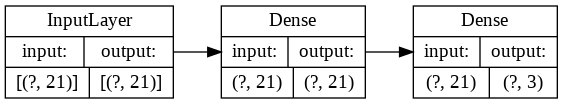

In [12]:
model = model_perceptron()
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=False,
    rankdir='LR',
    expand_nested=False,
)

In [19]:
model = model_perceptron()

################# Creating model_perceptron #################


In [0]:
def train_model(_model, _xtrain, _ytrain, _epochs = 1, _verbose = 0):
  return _model.fit(_xtrain, _ytrain, epochs=_epochs, verbose=_verbose)

def test_model(_model, _xtest, _ytest):
  print("Accuracy = {}".format(_model.evaluate(_xtest, _ytest)[1]))

In [21]:
trainedModel = train_model(model, features_resampled, training_cat_code_one_hot, _epochs=300,_verbose=0)
test_model(model, X_test, test_cat_code_one_hot)

#################       training model      #################
#################        Testing Model      #################
426/426 [==============================] - 0s 121us/sample - loss: 0.5277 - acc: 0.7629
Accuracy = 0.762910783290863


# <center> Model Comparison </center>

In [0]:

def pd_loss_acc_OverTime(_history):
  fig = pd.DataFrame({'Loss': _history.history['loss'], 'Accuracy': _history.history['acc']}, index=_history.epoch)
  fig.plot.line(subplots=True)
pd_loss_acc_OverTime(trainedModel)

In [0]:

def pd_mutiple_OverTime(trained_model_list):
  for _history in trained_model_list:
    fig = plt.plot(pd.DataFrame({'Accuracy': _history.history['acc']}, index=_history.epoch))
    fig = plt.xlabel('Epochs')
    fig = plt.ylabel('Accuracy')
  plt.show()

pd_mutiple_OverTime(trained_model_list)